# Thermochemical Equilibrium: Neutral ISM
Example of using `pism` to solve for thermochemical equilibrium in the unshielded neutral ISM. Line+recombination cooling balances photoelectric and cosmic ray heating, and gas-phase recombination balances cosmic-ray ionization.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp

## Defining the network

In [2]:
import pism
from pism.processes import FreeFreeEmission, LineCoolingSimple, CollisionalIonization, GasPhaseRecombination, Ionization
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
system = sum(processes)
system +=  sum([FreeFreeEmission(i) for i in ("H+", "He+", "He++")]) + sum([LineCoolingSimple(i) for i in ("H", "He+",)])

# throw in some order-of-magntiude numbers to model photoelectric heating and cosmic-ray ionization
heat_per_H = 1e-27
system.heat += heat_per_H * sp.Symbol("n_Htot")
zeta_CR = 2e-16
system += Ionization(species="H", rate_per_volume=zeta_CR* sp.Symbol("n_Htot"))
T = sp.Symbol("T")

# C+ cooling - assumes x_C+ = x_e- = 3e-4
x_C = 3e-4
system.heat -= 1e-27 * sp.Symbol("n_Htot") * sp.exp(-91.211 / T) * (4890 / sp.sqrt(T) *  (x_C *(sp.Symbol("n_Htot"))) + 0.47 * T**0.15 * sp.Symbol("n_Htot"))

# Solving thermochemical equilibrum

In [3]:
ngrid = np.logspace(-2,3,10**5)

knowns = {"n_Htot": ngrid,} 
y = pism.data.SolarAbundances.x("He")
guesses = {
    "T": 100. * np.ones_like(ngrid),
    "H": np.ones_like(ngrid)*0.5, 
    "He": y*0.5*np.ones_like(ngrid), 
    "He+": y*0.5*np.ones_like(ngrid)
}

sol = system.solve(knowns, guesses,verbose=True)

Undetermined symbols: {n_Htot, x_He+, x_H, x_He, y}
y not specified; assuming y=0.09254634923706946.
Free symbols: {n_Htot, T, x_He+, x_H, x_He, y}
Known values: ['n_Htot']
Assumed values: ['y']
Equations solved: ['He', 'heat', 'H', 'He+']
It's solvin time. Solving for {'T', 'He', 'He+', 'H'} based on input {'n_Htot'} and assumptions about {'y'}


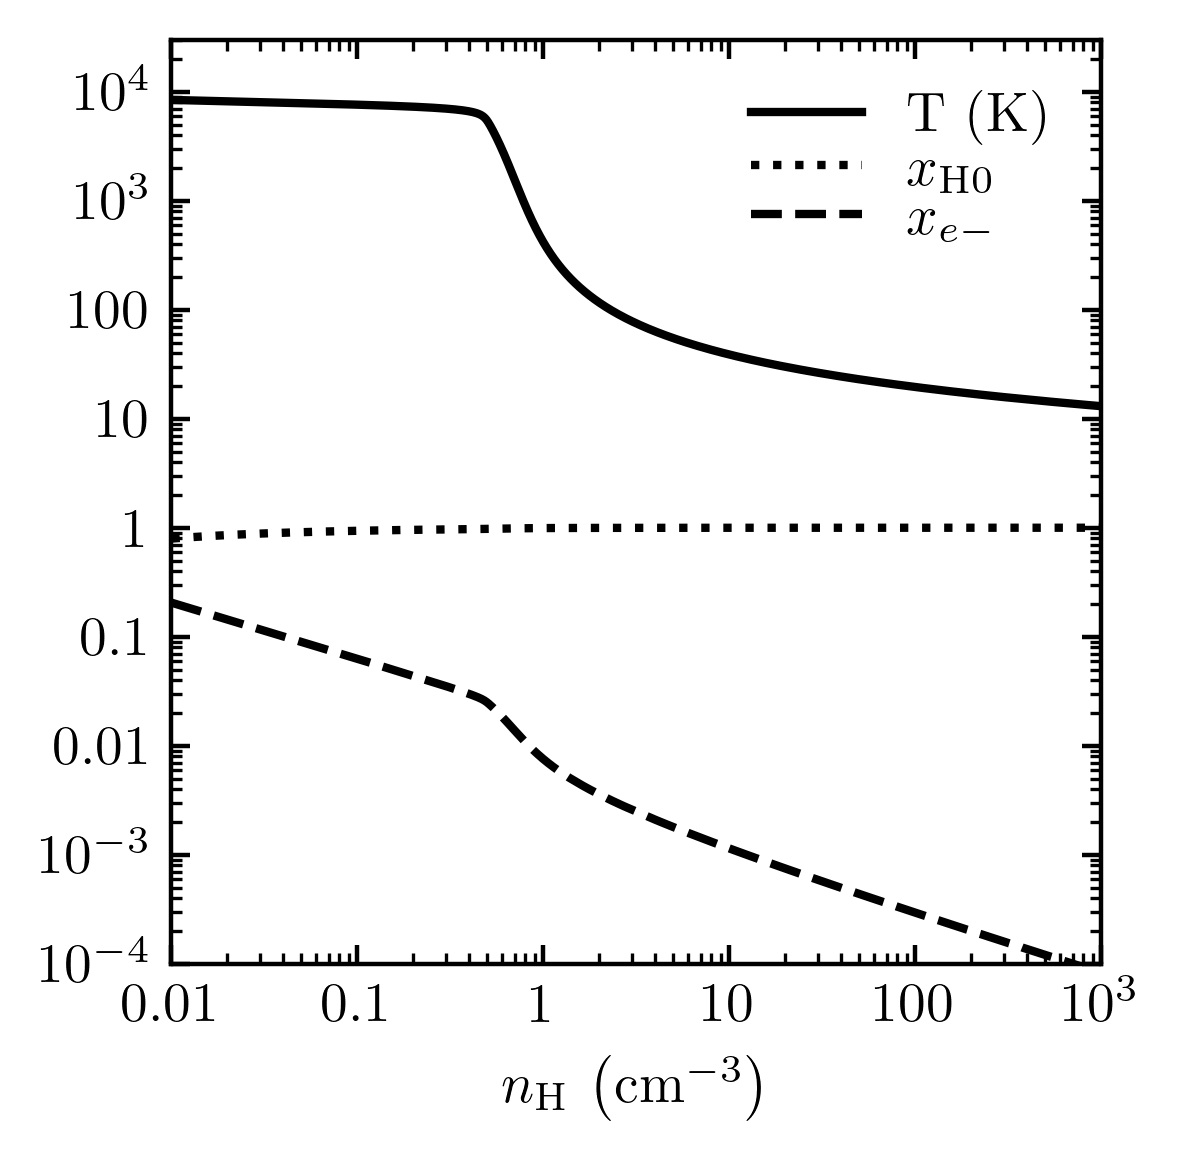

In [4]:
fig, ax = plt.subplots(figsize=(3,3))
ax.loglog(ngrid,sol["T"],label=r"T (K)",color='black')
ax.loglog(ngrid,sol["H"],label=r"$x_{\rm H0}$",ls='dotted',color='black')
ax.loglog(ngrid,sol["e-"],label=r"$x_{e-}$",ls='dashed',color='black')
ax.set_xlabel(r"$n_{\rm H}\,\left(\rm cm^{-3}\right)$")
ax.legend(labelspacing=0)
ax.set_xlim(ngrid[0],ngrid[-1])
ax.set_ylim(1e-4,3e4)
ax.set_yticks(10.**np.arange(-4,5))
ngrid0 = ngrid.copy()
sol_eq0 = sol.copy()

## Time integration: isochoric cooling from $10^4$ K

In [5]:
ngrid = np.logspace(-2,3,10**3) #np.array([1e-2])
T0 = 1e4

# start from an equilibrum solution at desired T
knowns = {"n_Htot": ngrid,"T":  T0 * np.ones_like(ngrid)} 
guesses = {
    "H": np.ones_like(ngrid)*0.01,
    "He": 0.24/(4-4*0.24)*np.ones_like(ngrid)*0.98, 
    "He+": 0.24/(4-4*0.24)*np.ones_like(ngrid)*0.01,
    "u": (T0/100)* 1e10*np.ones_like(ngrid)
}
sol_eq = system.solve(knowns, guesses,verbose=True)

Undetermined symbols: {n_Htot, T, x_He+, x_H, x_He, y}
y not specified; assuming y=0.09254634923706946.
Free symbols: {n_Htot, u, T, x_He+, x_H, x_He, y}
Known values: ['n_Htot', 'T']
Assumed values: ['y']
Equations solved: ['He', 'H', 'He+', 'u']
It's solvin time. Solving for {'He', 'u', 'He+', 'H'} based on input {'T', 'n_Htot'} and assumptions about {'y'}


In [6]:
import astropy.units as u
dt = 0.1 * u.Myr

knowns = {"n_Htot": ngrid, "u_0": sol_eq["u"]} 
guesses = {
    "T": T0 * np.ones_like(ngrid),
    "H": sol_eq["H"], 
    "He":sol_eq["He"],
    "He+": sol_eq["He+"],
    "u": sol_eq["u"]
}

solutions = []
for i in range(100):
    sol = system.solve(knowns, guesses, time_dependent=["T",], dt=dt,careful_steps=30)#,tol=1e-6)
    solutions.append(sol.copy())
    guesses = sol.copy() # let latest timestep be new initial guess
    knowns["u_0"] = np.copy(sol["u"]) # update initial internal energy for next timestep

(1, 20000.0)

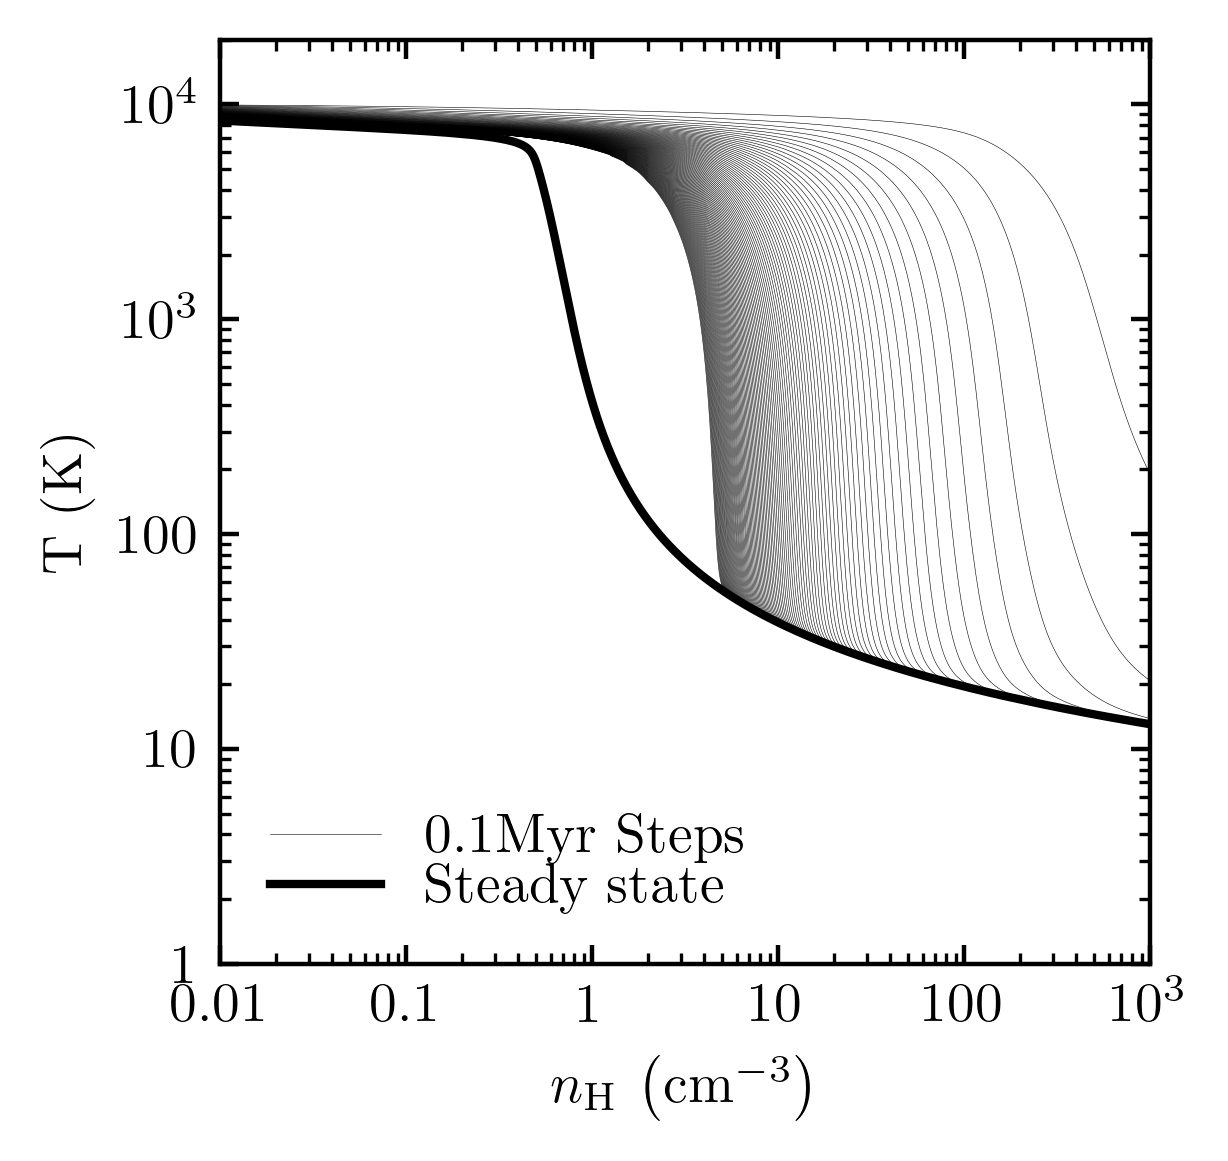

In [7]:
fig, ax = plt.subplots(figsize=(3,3))
dt_legend = True
for sol in solutions:
    ax.loglog(ngrid,sol["T"],color='black',lw=0.1,label=(r"$0.1\rm Myr$ Steps" if dt_legend else None))
    dt_legend = False
ax.loglog(ngrid0,sol_eq0["T"],color='black',label="Steady state")
ax.set_xlabel(r"$n_{\rm H}\,\left(\rm cm^{-3}\right)$")
ax.set_ylabel(r"T (K)")
ax.legend(labelspacing=0)
ax.set_xlim(ngrid[0],ngrid[-1])
ax.set_ylim(1,2e4)